In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [ ]:
obesity_ratio = pd.read_csv('D:/CASA0007-qm/assignment/ratefour.csv',low_memory=False)

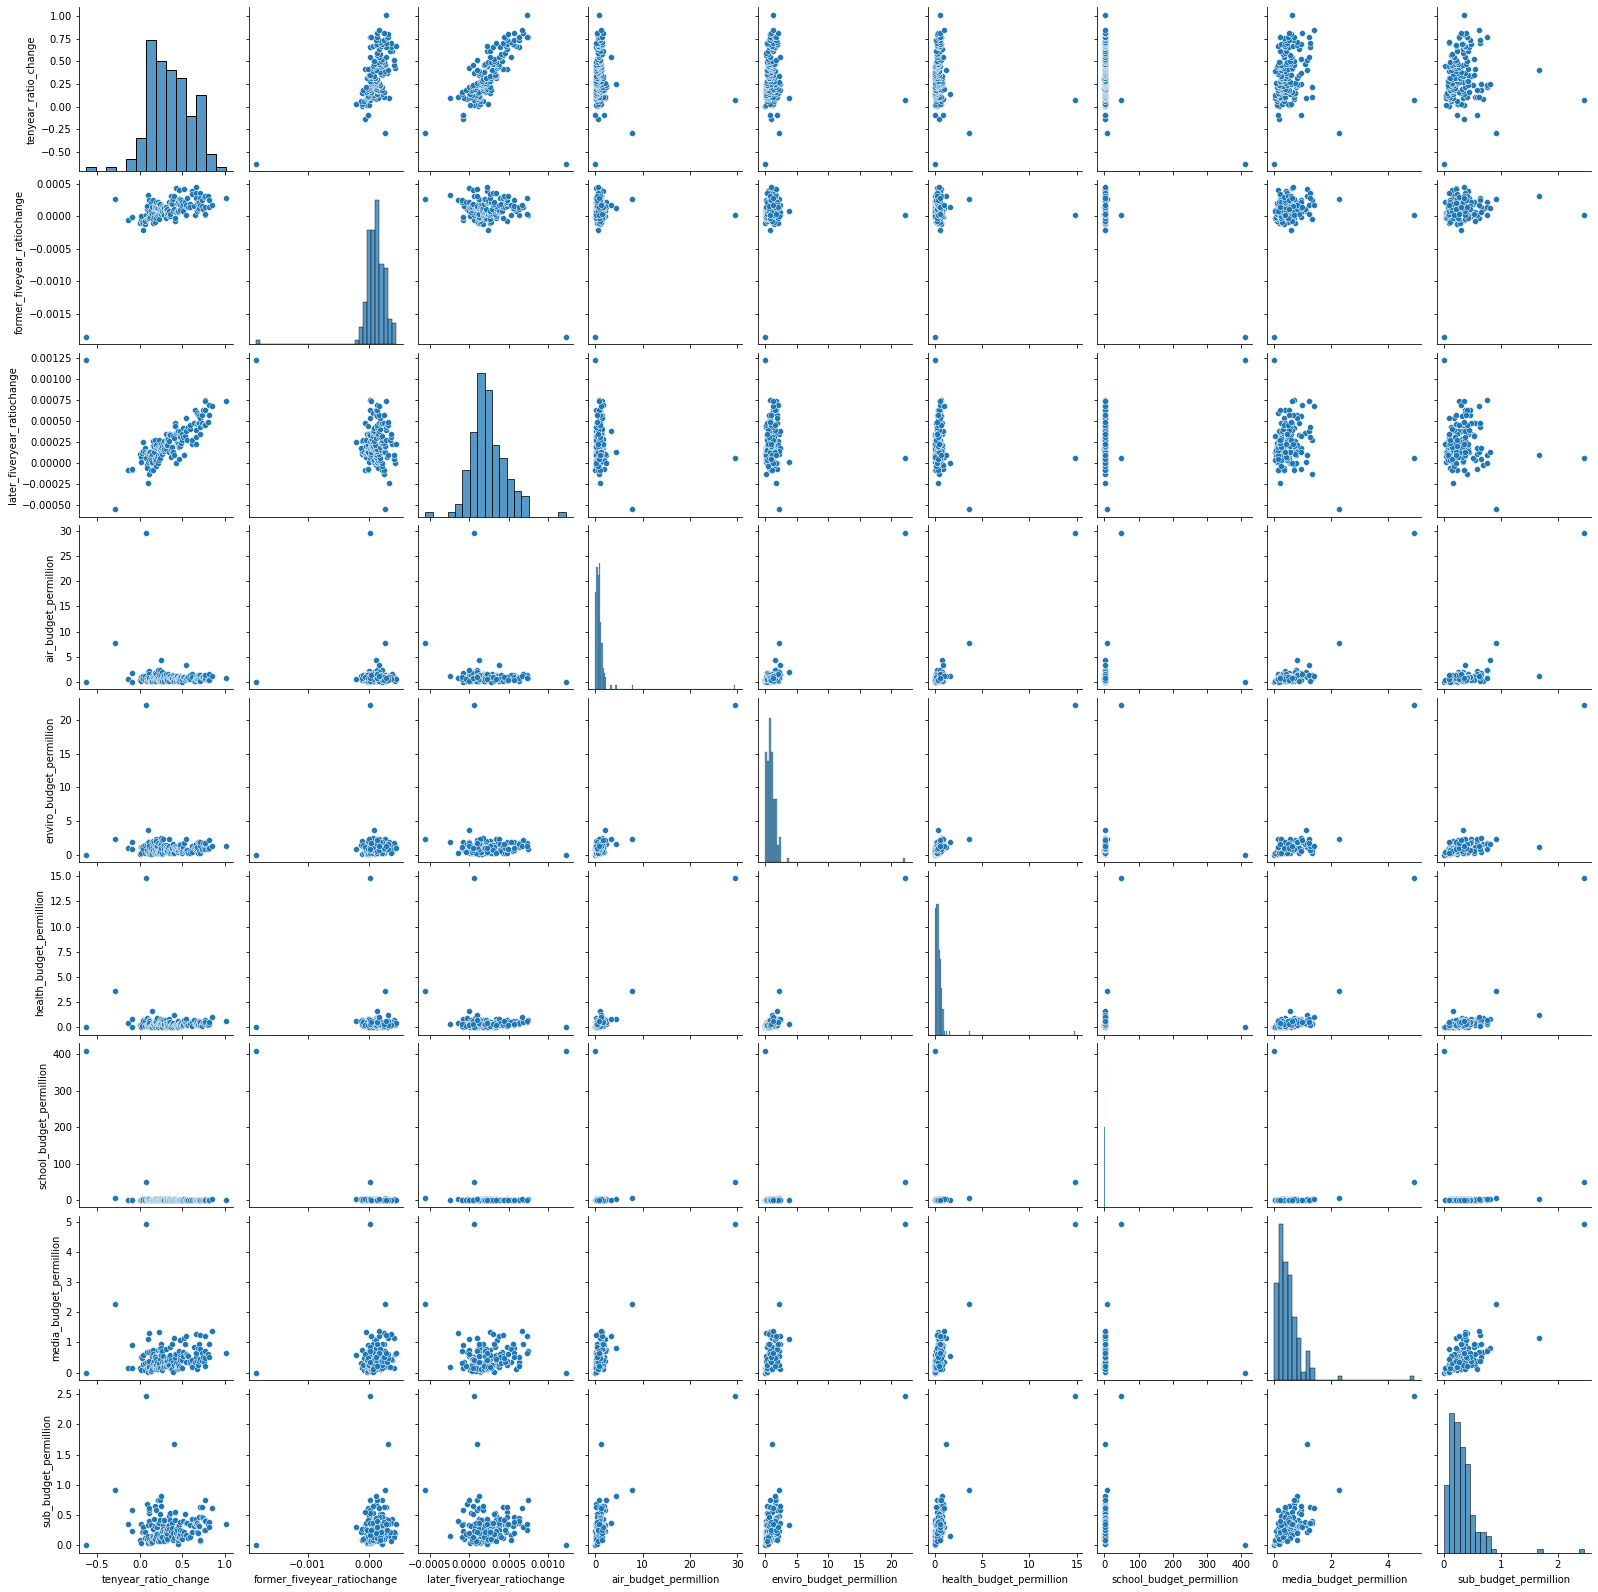

In [84]:
sns.pairplot(obesity_ratio)
plt.show()

In [128]:
# the former five year ratiochange
obesity_formerfiveyear = pd.read_csv('D:/CASA0007-qm/assignment/ratefive.csv',low_memory=False)

In [129]:
obesity_formerfiveyear.corrwith(obesity_ratio.former_fiveyear_ratiochange)

former_fiveyear_ratiochange    1.000000
air_budget_permillion          0.003586
enviro_budget_permillion       0.010014
health_budget_permillion      -0.001212
school_budget_permillion      -0.787101
media_budget_permillion        0.124798
sub_budget_permillion          0.101231
dtype: float64

In [130]:
y, X = dmatrices('former_fiveyear_ratiochange~air_budget_permillion+enviro_budget_permillion +school_budget_permillion+media_budget_permillion+sub_budget_permillion', data = obesity_ratio, return_type='dataframe')


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,3.411530,Intercept
1,10.594651,air_budget_permillion
2,9.009876,enviro_budget_permillion
3,1.020165,school_budget_permillion
4,3.643007,media_budget_permillion
5,2.566190,sub_budget_permillion


In [131]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [132]:
obesity_formerfiveyear.columns

Index(['former_fiveyear_ratiochange', 'air_budget_permillion',
       'enviro_budget_permillion', 'health_budget_permillion',
       'school_budget_permillion', 'media_budget_permillion',
       'sub_budget_permillion'],
      dtype='object')

In [133]:
df_predictors_selected_VIF = drop_column_using_vif_(obesity_formerfiveyear.drop('former_fiveyear_ratiochange', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

Dropping: health_budget_permillion
Dropping: air_budget_permillion
The columns remaining after VIF selection are:
Index(['enviro_budget_permillion', 'school_budget_permillion',
       'media_budget_permillion', 'sub_budget_permillion'],
      dtype='object')


In [134]:
model_obesity_formerfiveyear = sm.OLS(endog=obesity_ratio[['former_fiveyear_ratiochange']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_obesity_formerfiveyear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     former_fiveyear_ratiochange   R-squared:                       0.643
Model:                                     OLS   Adj. R-squared:                  0.633
Method:                          Least Squares   F-statistic:                     66.14
Date:                         Sun, 14 Nov 2021   Prob (F-statistic):           6.62e-32
Time:                                 08:30:18   Log-Likelihood:                 1155.0
No. Observations:                          152   AIC:                            -2300.
Df Residuals:                              147   BIC:                            -2285.
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     9.838e-05   1.61e-05      6.103      0.000    6.65e-05       0.000
enviro_budget_permillion -1.334e-05   9.15e-06     -1.458      0.147   -3.14e-05    4.74e-06
school_budget_permillion  -4.77e-06   3.02e-07    -15.779      0.000   -5.37e-06   -4.17e-06
media_budget_permillion    8.87e-05   3.66e-05      2.427      0.016    1.65e-05       0.000
sub_budget_permillion     9.116e-06   5.76e-05      0.158      0.874      -0.000       0.000
==============================================================================
Omnibus:                        1.119   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.911
Skew:                           0.188   Prob(JB):                        0.634
Kurtosis:                       3.048   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
d1 = pd.read_csv('D:/CASA0007-qm/assignment/ratefive.csv',low_memory=False)

In [136]:
d1.head()

,former_fiveyear_ratiochange,air_budget_permillion,enviro_budget_permillion,health_budget_permillion,school_budget_permillion,media_budget_permillion,sub_budget_permillion
0,-0.001853,0.000000,0.000000,0.000000,409.836066,0.000000,0.000000
1,0.000264,7.760601,2.282530,3.652048,6.391083,2.282530,0.913012
2,-0.000054,0.547962,1.001448,0.434591,1.454934,0.170057,0.359010
3,-0.000014,0.055421,0.796047,0.055421,0.629784,0.146110,0.231760
4,-0.000016,1.864081,1.864081,0.873788,0.932041,0.932041,0.582525


In [137]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [138]:
d1 = d1.rename(columns = {'former_fiveyear_ratiochange':'formerfiveratiochange',
                          'school_budget_permillion':'school',
                          'enviro_budget_permillion':'environment',
                          'media_budget_permillion':'media'})

multi_regression_model_1 = smf.ols(formula='formerfiveratiochange ~ school + media + environment',data=d1).fit()

print(multi_regression_model_1.summary())

                              OLS Regression Results                             
Dep. Variable:     formerfiveratiochange   R-squared:                       0.643
Model:                               OLS   Adj. R-squared:                  0.636
Method:                    Least Squares   F-statistic:                     88.76
Date:                   Sun, 14 Nov 2021   Prob (F-statistic):           6.51e-33
Time:                           08:30:28   Log-Likelihood:                 1154.9
No. Observations:                    152   AIC:                            -2302.
Df Residuals:                        148   BIC:                            -2290.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.946e-

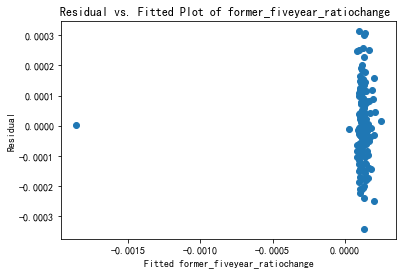

In [160]:
# plot 
plt.scatter(model_obesity_formerfiveyear.fittedvalues, model_obesity_formerfiveyear.resid)
# adding title and labels
plt.xlabel('Fitted former_fiveyear_ratiochange')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of former_fiveyear_ratiochange ')
plt.show()

In [141]:
# the later-five-year model
obesity_laterfiveyear = pd.read_csv('D:/CASA0007-qm/assignment/ratesix.csv',low_memory=False)

In [142]:
obesity_laterfiveyear.corrwith(obesity_laterfiveyear.later_fiveyear_ratiochange)

later_fiveyear_ratiochange    1.000000
air_budget_permillion        -0.138361
enviro_budget_permillion     -0.070943
health_budget_permillion     -0.122142
school_budget_permillion      0.352399
media_budget_permillion      -0.040854
sub_budget_permillion        -0.056760
dtype: float64

In [145]:
y, X = dmatrices('later_fiveyear_ratiochange~air_budget_permillion+enviro_budget_permillion +school_budget_permillion+media_budget_permillion+sub_budget_permillion', data = obesity_laterfiveyear, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,3.411530,Intercept
1,10.594651,air_budget_permillion
2,9.009876,enviro_budget_permillion
3,1.020165,school_budget_permillion
4,3.643007,media_budget_permillion
5,2.566190,sub_budget_permillion


In [146]:
obesity_laterfiveyear.columns

Index(['later_fiveyear_ratiochange', 'air_budget_permillion',
       'enviro_budget_permillion', 'health_budget_permillion',
       'school_budget_permillion', 'media_budget_permillion',
       'sub_budget_permillion'],
      dtype='object')

In [149]:
df_predictors_selected_VIF = drop_column_using_vif_(obesity_laterfiveyear.drop('later_fiveyear_ratiochange', axis=1))

print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

model_obesity_laterfiveyear = sm.OLS(endog=obesity_laterfiveyear[['later_fiveyear_ratiochange']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()
model_obesity_laterfiveyear.summary()

Dropping: health_budget_permillion
Dropping: air_budget_permillion
The columns remaining after VIF selection are:
Index(['enviro_budget_permillion', 'school_budget_permillion',
       'media_budget_permillion', 'sub_budget_permillion'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     later_fiveyear_ratiochange   R-squared:                       0.135
Model:                                    OLS   Adj. R-squared:                  0.112
Method:                         Least Squares   F-statistic:                     5.740
Date:                        Sun, 14 Nov 2021   Prob (F-statistic):           0.000255
Time:                                08:35:04   Log-Likelihood:                 1076.4
No. Observations:                         152   AIC:                            -2143.
Df Residuals:                             147   BIC:                            -2128.
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0002    2.7e-05      8.595      0.000       0.000       0.000
enviro_budget_permillion -1.786e-05   1.53e-05     -1.164      0.246   -4.82e-05    1.25e-05
school_budget_permillion  2.373e-06   5.07e-07      4.681      0.000    1.37e-06    3.37e-06
media_budget_permillion    3.45e-05   6.13e-05      0.563      0.574   -8.66e-05       0.000
sub_budget_permillion    -7.389e-06   9.66e-05     -0.077      0.939      -0.000       0.000
==============================================================================
Omnibus:                        6.475   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.039   Jarque-Bera (JB):               10.854
Skew:                           0.016   Prob(JB):                      0.00440
Kurtosis:                       4.309   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#The later five year R-squared was lower than 0.5, so this model was not suitable. The former five-year model performed better with the R-Squared was 0.643.